<a href="https://colab.research.google.com/github/fsemecurbe/MMTMSS/blob/main/MMTMSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate Multifractals To Modelize Spatial Segregation

In [3]:
import pandas as pd
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage.measure import block_reduce

## Functions

In [4]:
def multivariate_lognormal_cascade(n, sigma1=1, sigma2=1, corr=0):
    mu1 = -1/2 * sigma1**2
    mu2 = -1/2 * sigma2**2

    PQ = np.exp(rng.multivariate_normal(np.array([mu1,mu2]),  np.array([[sigma1**2,corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]), 4))

    P = PQ[:,0].reshape(2,2)
    Q = PQ[:,1].reshape(2,2)
    for i in range(n):
        PQ = np.exp(rng.multivariate_normal(np.array([mu1,mu2]),np.array([[sigma1**2,corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]), P.shape[0]**2 * 4))
        P = np.kron(P, np.ones((2,2)))
        P = P * PQ[:,0].reshape(P.shape)
        Q = np.kron(Q, np.ones((2,2)))
        Q = Q * PQ[:,1].reshape(P.shape)

    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    return(np.stack([P,Q], axis=-1))

#### Test de la fonction multivariate_lognormal_cascade

In [3]:
lnc = multivariate_lognormal_cascade(6, sigma1=.4, sigma2=.4, corr=.0)
ratio = .2 * lnc[:,:,0] / (.2 * lnc[:,:,0] + .8 * lnc[:,:,1]) * 100

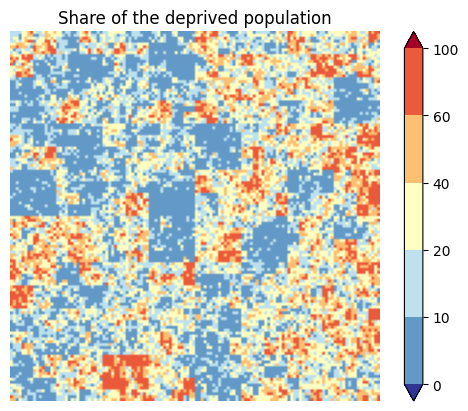

In [4]:
cmap = mpl.cm.RdYlBu_r
bounds = [0, 10, 20, 40, 60, 100]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
ax.set_axis_off();
ax.set_title('Share of the deprived population');
ax.imshow(cmap(norm(ratio)))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax);

### Calcul d'entropie

In [143]:
lnc = multivariate_lognormal_cascade(8, sigma1=.5, sigma2=.4, corr=.0)
pop = lnc[:,:,0]
pop = block_reduce(pop, block_size = (4,4), func = np.sum)

3.188589182162459
2.693482164441158
2.1636812284004003
1.6186982035902542


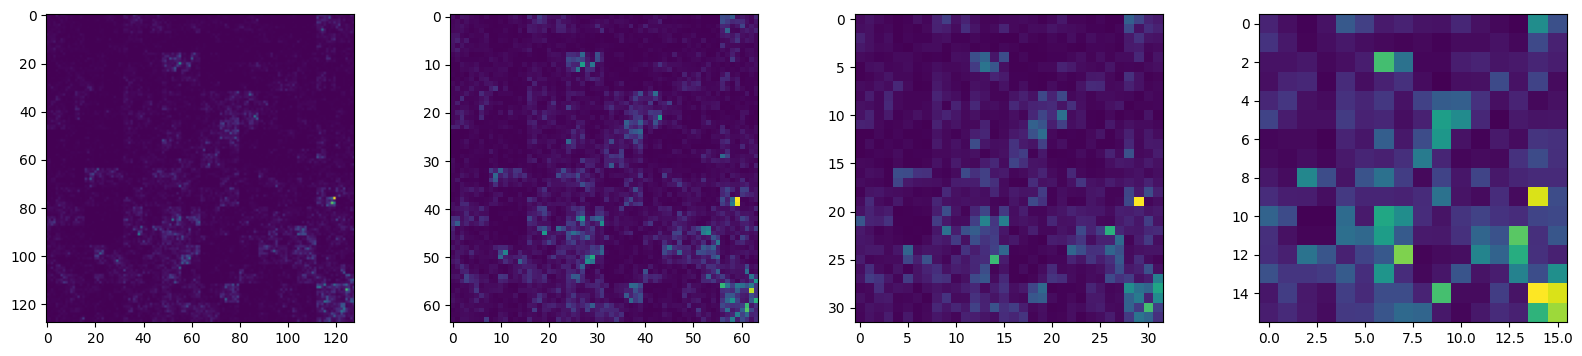

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
  small_arr = block_reduce(pop, block_size=(2**i,2**i), func=np.sum)
  axs[i].imshow(small_arr)
  print(np.var(np.log2(small_arr.flatten())))

(array([  1.,   1.,   1.,   3.,   9.,   9.,  24.,  35.,  59.,  79., 121.,
        172., 199., 273., 348., 477., 546., 604., 670., 782., 861., 896.,
        932., 971., 990., 971., 850., 833., 788., 687., 618., 530., 459.,
        420., 279., 232., 180., 140., 110.,  67.,  58.,  35.,  27.,  21.,
         10.,   2.,   1.,   0.,   2.,   1.]),
 array([-21.61620602, -21.34749472, -21.07878343, -20.81007214,
        -20.54136085, -20.27264955, -20.00393826, -19.73522697,
        -19.46651567, -19.19780438, -18.92909309, -18.6603818 ,
        -18.3916705 , -18.12295921, -17.85424792, -17.58553662,
        -17.31682533, -17.04811404, -16.77940275, -16.51069145,
        -16.24198016, -15.97326887, -15.70455757, -15.43584628,
        -15.16713499, -14.8984237 , -14.6297124 , -14.36100111,
        -14.09228982, -13.82357852, -13.55486723, -13.28615594,
        -13.01744465, -12.74873335, -12.48002206, -12.21131077,
        -11.94259947, -11.67388818, -11.40517689, -11.1364656 ,
        -10.867754

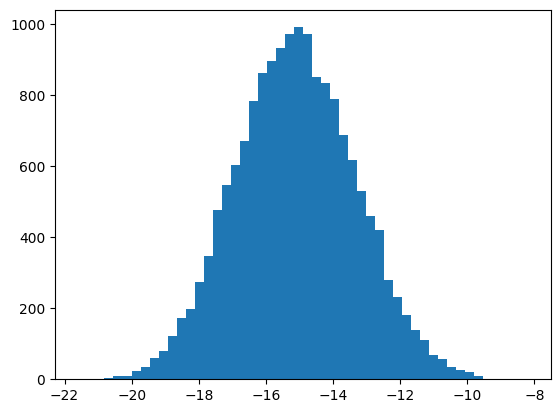

In [7]:
plt.hist(np.log2(pop.flatten('F')), bins=100)

### Valeur de alpha pour alpha = 0 et la variance de la parabole

---



In [157]:
sigma = .15
res = []
res2 = []
for i in range(10):
  lnc = multivariate_lognormal_cascade(10, sigma1=sigma, sigma2=.4, corr=.0)
  pop = block_reduce(lnc[:,:,0], block_size = (16,16), func = np.sum)
  entropies =  []
  entropies2 = []
  scales = np.array([i for i in range(1,4)])
  for i in scales:
     small_arr = block_reduce(pop, block_size=(2**i,2**i), func=np.sum)
     entropies.append(-np.mean(np.log2(small_arr)))
     entropies2.append(-np.var(np.log2(small_arr)))
  entropies = np.array(entropies)
  entropies2 = np.array(entropies2)
  res.append(-np.sum((entropies - entropies.mean()) * (scales - scales.mean())) / np.sum((scales - scales.mean())**2))
  res2.append(-np.sum((entropies2 - entropies2.mean()) * (scales - scales.mean())) / np.sum((scales - scales.mean())**2))
np.mean(res), np.mean(res2)

(np.float64(2.015938696696314), np.float64(-0.04608318379167019))

In [158]:
2 + sigma**2/2 / np.log(2), sigma**2 * 2

(np.float64(2.016230319210001), 0.045)

### Valeur de f(alpha) = alpha pour alpha = 1

In [152]:
sigma = .5
res = []
for i in range(500):
  lnc = multivariate_lognormal_cascade(10, sigma1=sigma, sigma2=.4, corr=.0)
  pop = block_reduce(lnc[:,:,0], block_size = (16,16), func = np.sum)
  entropies =  []
  scales = np.array([i for i in range(1,4)])
  for i in scales:
     small_arr = block_reduce(pop, block_size=(2**i,2**i), func=np.sum)
     entropies.append(-np.sum(small_arr * np.log2(small_arr)))
  entropies = np.array(entropies)
  res.append(-np.sum((entropies - entropies.mean()) * (scales - scales.mean())) / np.sum((scales - scales.mean())**2))
np.mean(res)

KeyboardInterrupt: 

In [ ]:

mu = -1/2 * sigma**2 - np.log(4)

res = []
for i in range(10000000):
  samples = np.exp(np.random.normal(mu, sigma, size=4))
  #samples = samples / samples.sum()
  res.append(-np.sum(samples * np.log2(samples)))

print(np.mean(res))

Vraie Valeur

In [ ]:
2 - ((sigma**2)/2 / np.log(2))

In [ ]:
res = []
for i in range(1000000):
  samples = np.exp(np.random.normal(mu, sigma, size=4))
  res.append(samples.sum())
np.mean(res)

np.float64(0.9999320967820047)

In [ ]:
np.sum((entropies - entropies.mean()) * (scales - scales.mean())) / np.sum((scales - scales.mean())**2)

np.float64(-1.4638276075246432)